In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
%matplotlib inline

C:\Users\kagiencz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\kagiencz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Compare the accuracy of prediction of the values of Robusta coffee time series with AR(1) and ARIMA(1,1,0) models.

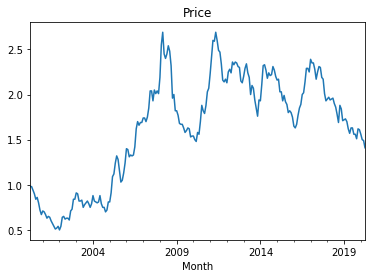

In [17]:
df = pd.read_csv('cofee.csv', index_col='Month', parse_dates=True)
df.index.freq = 'MS'
df.dropna(inplace=True)
df['Price'].plot(title='Price')

In [9]:
train = df.iloc[:int(0.7*len(df))]
test = df.iloc[int(0.7*len(df)):]
train.head()

,Price,Change
Month,,
2000-04-01,0.98,-
2000-05-01,0.98,0.00 %
2000-06-01,0.94,-4.08 %
2000-07-01,0.90,-4.26 %
2000-08-01,0.84,-6.67 %


In [4]:
model_ARIMA = ARIMA(df['Price'], order=(1,1,0))
ARIMA_results = model_ARIMA.fit(disp=0)

In [5]:
model_AR = ARMA(df['Price'], order=(1,0))
AR_results = model_AR.fit(disp=0)

In [7]:
start = len(train)
end = len(train) + len(test) - 1
ARIMA_predictions = ARIMA_results.predict(start=start, end=end, dynamic=False).rename('ARIMA(1, 1, 0) Predictions')
AR_predictions = AR_results.predict(start=start, end=end, dynamic=False).rename('AR1 Predictions')

In [15]:
from sklearn.metrics import mean_squared_error
ARIMA_error = mean_squared_error(test['Price'], ARIMA_predictions)
print(ARIMA_error)
AR_error = mean_squared_error(test['Price'], AR_predictions)
print(AR_error)

3.8311233219870173
0.0050522237529377415


### Forecast the monthly consumption of natural gas in the US using the SARIMA model

In [57]:
df = pd.read_csv('natural_gas.csv', sep=";", index_col='Date')
df = df.rename(columns={"Date": "Date", "U.S. Natural Gas Total Consumption (MMcf)": "Gas Consumption"})
df['date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df.set_index('date', inplace=True)
df.index.freq='MS'
df.head()

,Year,Month,Gas Consumption
date,,,
2001-01-01,2001,1,2676998
2001-02-01,2001,2,2309464
2001-03-01,2001,3,2246633
2001-04-01,2001,4,1807170
2001-05-01,2001,5,1522382


Ok, yeah, I went and changed the data manually (thank gods for Excel macros) to reuse the code from the lecture. I know it may seem like cheating a little bit, but that's not the focus of this task I think, and I was slowly going [insane with trying to get the datetime to work](https://www.youtube.com/watch?v=-5wpm-gesOY)

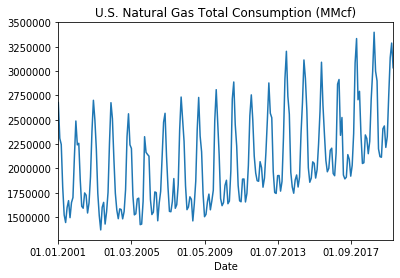

In [51]:
df['Gas Consumption'].plot(title = "U.S. Natural Gas Total Consumption (MMcf)")

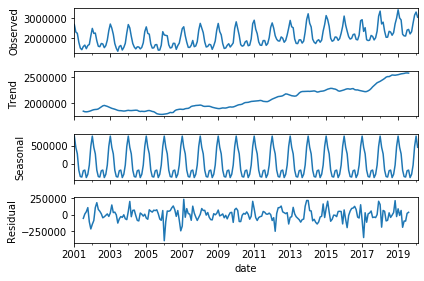

In [58]:
result = seasonal_decompose(df["Gas Consumption"], model='add')
result.plot();

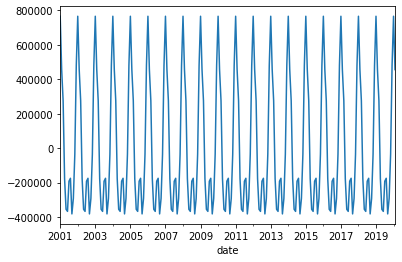

In [59]:
result.seasonal.plot()

In [69]:
stepwise_fit = auto_arima(df['Gas Consumption'], max_order=12, d=1, D=1, m=12, max_p=2, max_q=3, max_P=1, max_Q=1, 
                          stepwise=False, trace=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=5718.953, BIC=5745.992, Fit time=1.370 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=5720.473, BIC=5750.892, Fit time=1.544 seconds
Total fit time: 2.918 seconds


In [65]:
train = df.iloc[:int(0.7*len(df))]
test = df.iloc[int(0.7*len(df)):]

In [70]:
model = SARIMAX(train['Gas Consumption'], order=(2,1,3), seasonal_order=(1,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                    Gas Consumption   No. Observations:                  161
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -1940.514
Date:                            Thu, 28 May 2020   AIC                           3897.029
Time:                                    15:34:27   BIC                           3921.006
Sample:                                01-01-2001   HQIC                          3906.771
                                     - 05-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2127      0.128     -9.452      0.000      -1.464      -0.961
ar.L2         -0.7773      0.161     -4.814      0.000      -1.094      -0.461
ma.L1          1.0395      0.126      8.276      0.000       0.793       1.286
ma.L2          0.4873      0.175      2.789      0.005       0.145       0.830
ma.L3         -0.2232      0.060     -3.706      0.000      -0.341      -0.105
ar.S.L12       0.4761      0.099      4.812      0.000       0.282       0.670
ma.S.L12      -0.8266      0.115     -7.175      0.000      -1.052      -0.601
sigma2       1.55e+10   5.82e-12   2.66e+21      0.000    1.55e+10    1.55e+10
===================================================================================
Ljung-Box (Q):                       41.52   Jarque-Bera (JB):                 7.58
Prob(Q):                              0.40   Prob(JB):                         0.02
Heteroskedasticity (H):               0.73   Skew:                            -0.37
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+37. Standard errors may be unstable.
"""

In [72]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(2, 1, 3)x(1, 1, 1, 12) Predictions')
predictions.head()

2014-06-01    1.814047e+06
2014-07-01    1.973373e+06
2014-08-01    1.990985e+06
2014-09-01    1.814814e+06
2014-10-01    1.900214e+06
Freq: MS, Name: SARIMA(2, 1, 3)x(1, 1, 1, 12) Predictions, dtype: float64

[Text(0, 0.5, 'Million Cubic Feet'), Text(0.5, 0, 'Date')]

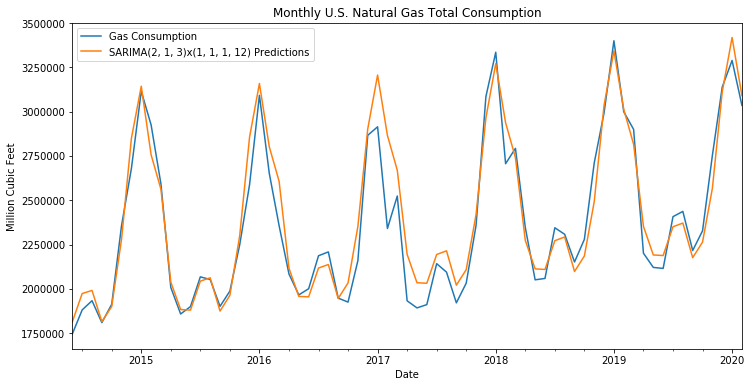

In [80]:
title='Monthly U.S. Natural Gas Total Consumption'
ylabel = 'Million Cubic Feet'
xlabel = 'Date'

ax = test['Gas Consumption'].plot(legend=True, figsize=(12,6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [78]:
model = SARIMAX(df['Gas Consumption'], order=(2,1,3), seasonal_order=(1,1,1,12))
results = model.fit()
forecast = results.predict(len(df), len(df)+11).rename('SARIMA Forecast')

[Text(0, 0.5, 'Million Cubic Feet'), Text(0.5, 0, 'Date')]

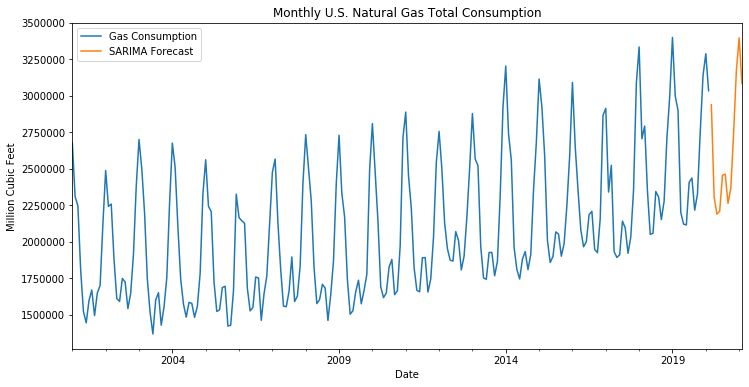

In [81]:
title='Monthly U.S. Natural Gas Total Consumption'
ylabel = 'Million Cubic Feet'
xlabel = 'Date'

ax = df['Gas Consumption'].plot(legend=True, figsize=(12,6), title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)